# Project 2 Ames Housing
## Pipeline linear modeling

This approach closely follows that presented in class by Mark Popovich and references notes by Douglas Strodtman (SaMo).  


## Import libraries

In [27]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, RFE

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

from scipy import stats
import statsmodels.api as sm

from itertools import combinations

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [28]:
# Set relative data path
data_path = "../datasets"
test_dataframe_name = "test_clean.csv"
train_dataframe_name = "train_clean.csv"
y_trn_dataframe_name = "y_clean.csv"

X1_trn = pd.read_csv(os.path.join(data_path, train_dataframe_name))
X1_tst = pd.read_csv(os.path.join(data_path, test_dataframe_name))
y_trn = pd.read_csv(os.path.join(data_path, y_trn_dataframe_name))

print(X1_trn.shape, X1_tst.shape, y_trn.shape)

(2051, 274) (879, 274) (2051, 1)


In [29]:
# Establish lists of variable types
# Establish lists of variable types
cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'misc_feat','sale_type',
                'street', 'lot_shape','land_cont', 'land_slop', 'cond1', 'cond2',
                'roof_style', 'roof_matl','ext_1st', 'ext_2nd', 'mas_vnr_type', 'found','bsmt_qual',
                'bsmt_exp','bsmt_fin_type_1','bsmt_fin_type_2','heating','electrical',
                'fireplc_qu','garg_fnsh','garg_qlty','garg_cnd','pvd_drive']

num_features = ['lot_area', 'over_qual', 'over_cond',
                'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold', 'mas_vnr_area', 'bsmt_fin_sf',
                'bsmt_fin_sf_2','bsmt_unf_sf','low_qual_fin_sf','kitch_abv_gr','tot_rms_abv_grd',
                'fireplcs','garg_cars', 'garg_area','wood_dck_sf', 'opn_prch_sf',
                '3sn_prch', 'scrn_prch', 'pool_area','misc_val','1st_flr_sf', '2nd_flr_sf',
                'age_home_at_sale','age_remodel_at_sale']


### Use polynomial features to add higher order terms

In [30]:
# Consider only interaction terms of the numerical columns
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X1_trn_p = pd.DataFrame(poly.fit_transform(X1_trn[num_features]))
X1_trn_p.columns = poly.get_feature_names(num_features)

X1_tst_p = pd.DataFrame(poly.fit_transform(X1_tst[num_features]))
X1_tst_p.columns = poly.get_feature_names(num_features)


In [31]:
# Drop the numerical variables from the train and test columns
X1_trn_temp = X1_trn.drop(columns = num_features)
X1_tst_temp = X1_tst.drop(columns = num_features)

print(X1_trn_p.shape)
print(X1_tst_p.shape)
print(X1_trn_temp.shape)
print(X1_tst_temp.shape)


(2051, 561)
(879, 561)
(2051, 241)
(879, 241)


In [32]:
# recombine the polynomial transformed variables with the categorical variables
X1_trn = X1_trn_p.join(X1_trn_temp)
X1_tst = X1_tst_p.join(X1_tst_temp)
print(X1_trn.shape)
print(X1_tst.shape)



(2051, 802)
(879, 802)


### Split the training data into training and testing subsets

In [33]:
# Split the training data
X1_trn_trn, X1_trn_tst, y_trn_trn, y_trn_tst = train_test_split(X1_trn, y_trn, random_state=223)


### Scale the data

In [34]:
# Use the standard scaler to scale the data
ss = StandardScaler()
ss.fit(X1_trn_trn)
X1_trn_trn_s = pd.DataFrame(ss.transform(X1_trn_trn))
X1_trn_trn_s.columns = X1_trn_trn.columns
X1_trn_tst_s = pd.DataFrame(ss.transform(X1_trn_tst))
X1_trn_tst_s.columns = X1_trn_tst.columns


## Define functions


In [60]:
def eval_model(y_act, y_pred):
    
    # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,12))

    fig.suptitle('Model analysis', fontsize = 16)
    
    # Plot the scatter of the predicted versus actual
    ax[0][0] = sns.scatterplot('act','pred', data=df, ax = ax[0][0])
    ax[0][0] = sns.lineplot('act','act', data=df, ax = ax[0][0], color = 'grey')
    ax[0][0].set_title('Predicted versus actuals', fontsize = 14)
    ax[0][0].set_xlabel('Actuals', fontsize = 12)
    ax[0][0].set_ylabel('Predicted', fontsize = 12)
    ax[0][0].text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left',
                  size='large', color='grey', weight='semibold', transform=ax[0][0].transAxes)
    ax[0][0].grid(False)
    
    # Plot the scatter of the residuals versus actuals
    ax[0][1] = sns.scatterplot(x = 'act',y = 'res', data=df, ax = ax[0][1])
    ax[0][1].set_title('Residuals versus actuals', fontsize = 14)
    ax[0][1].set_xlabel('Actuals', fontsize = 12)
    ax[0][1].set_ylabel('Residuals', fontsize = 12)
    ax[0][1].axhline(y=0, color = 'grey')
    ax[0][1].grid(False)
    
    # Plot the residuals
    ax[1][0] = sns.scatterplot(x = df.index,y = 'res', data=df, ax = ax[1][0])
    ax[1][0].set_title('Residuals versus an index', fontsize = 14)
    ax[1][0].set_xlabel('Index', fontsize = 12)
    ax[1][0].set_ylabel('Residuals', fontsize = 12)
    ax[1][0].axhline(y=0, color = 'grey')
    ax[1][0].grid(False)
    
    # Plot the histogram of residuals
    ax[1][1] = sns.distplot( df['res'], ax = ax[1][1])
    ax[1][1].set_title('Histogram of residuals', fontsize = 14)
    ax[1][1].set_xlabel('Residuals', fontsize = 12)
    ax[1][1].set_ylabel('Distribution', fontsize = 12)
    ax[1][1].text(.05,.95, f"p value for $H_0$: residuals are normal {r2:.4}", 
                  horizontalalignment='left', size='large', color='grey', weight='semibold', 
                  transform=ax[1][1].transAxes)
    ax[1][1].grid(False)
    
    # https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
    # https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html


def write_pred(df, out_file):
    # Open the test file to get the ID
    test_file_name = "test.csv"
    a_tst = pd.read_csv(os.path.join(data_path, test_file_name))
    pred_out = a_tst[['Id']].join(df).sort_values(by='Id')
    # Save the predictions to a csv file
    pred_out.to_csv(os.path.join(data_path, out_file), header = ['Id','SalePrice'], index = False)
    
    # https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
    # https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/

    
def view_lr_summary(X,y):    
    # Use stats models to generate a summary of the regression
    # Copy the X and y and reset index of y to be equal to x
    X1 = X.copy()
    y1 = y.copy()
    y1.index = X1.index
    X1 = sm.add_constant(X1)
    model = sm.OLS(y1, X1)
    results =  model.fit()
    # return the results
    return results.summary()


def large_scatter(y_act, y_pred):
     # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16,14))

    # Plot the scatter of the predicted versus actual
    ax = sns.scatterplot('act','pred', data=df, ax = ax, s=200, legend = False)
    ax = sns.lineplot('act','act', data=df, ax = ax, color = 'grey', size=['act'], sizes = [5], legend = False)
    ax.set_title('Predicted versus actuals', fontsize = 40, color = 'grey', weight = 'semibold')
    ax.set_xlabel('Actuals', fontsize = 30, color = 'grey', weight = 'semibold')
    ax.set_ylabel('Predicted', fontsize = 30, color = 'grey',weight = 'semibold')
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left', fontsize = 40,
                  color='grey', weight='semibold', transform=ax.transAxes)
    ax.grid(False)
 

## Work with a pipeline

### Create a pipe

In [37]:
# Create a pip
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest',SelectKBest(f_regression, k = 10)),
    ('rfe', RFE(Lasso(),n_features_to_select=None))
])


### Establish a grid

In [38]:
# Establish the grid parameters to search
# In this case we are calling the kbesdt evaluation object and 
# and Recursive Feature Elimination (RFE)

# k_best_p = [10, 20, 30, 40, 50]
# ref_p = [5, 7, 9, 11, 20, 30]

k_best_p = [10, 20, 30, 40, 50]
ref_p = [5, 7, 9]


params = {
    'kbest__k': k_best_p,
    'rfe__n_features_to_select': ref_p
}


In [39]:
# Instantiate the grid search object
gs_model = GridSearchCV(pipe, params)


### Fit and score the model

In [40]:
# fit the model - use the unscaled data since the pipe scales
gs_model.fit(X1_trn_trn, y_trn_trn)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a255c5400>)), ('rfe', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [10, 20, 30, 40, 50], 'rfe__n_features_to_select': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
# Generate predictions from the 
pred_gs_trn_tst = gs_model.predict(X1_trn_tst)


In [46]:
# score the training data
print(gs_model.score(X1_trn_trn, y_trn_trn))
print(gs_model.score(X1_trn_tst, y_trn_tst))


0.8367999766394499
0.8117735198565008


## Evaluate the model

### Use the eval_model function to examine predictions and residuals

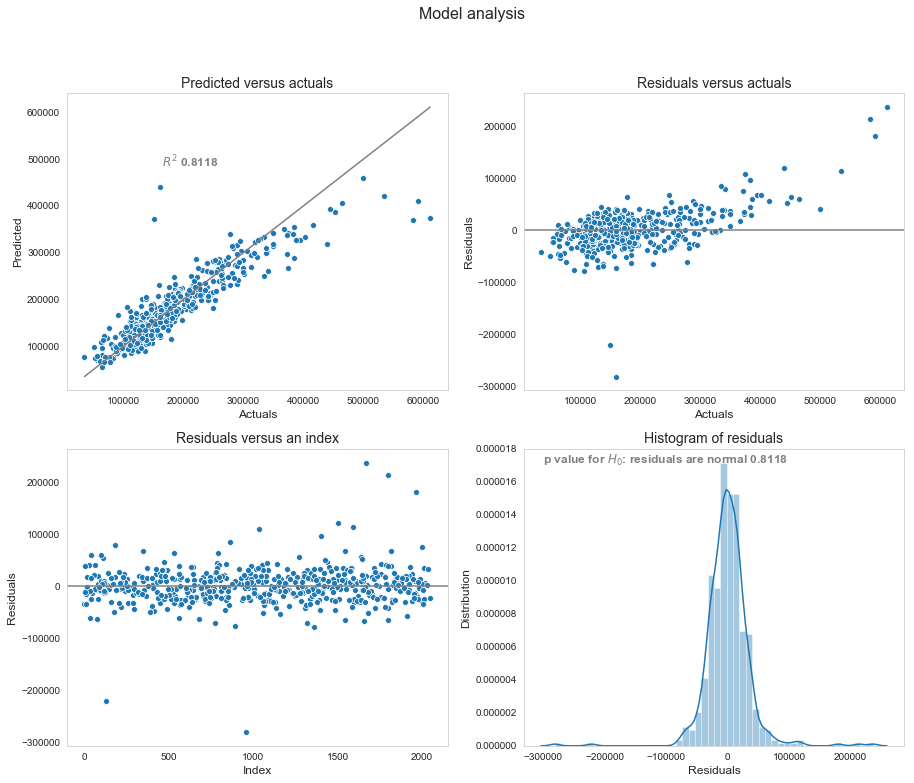

In [47]:
# Examine the model's performance
eval_model(y_trn_tst, pred_gs_trn_tst)


### Create a large scatter for the presentation

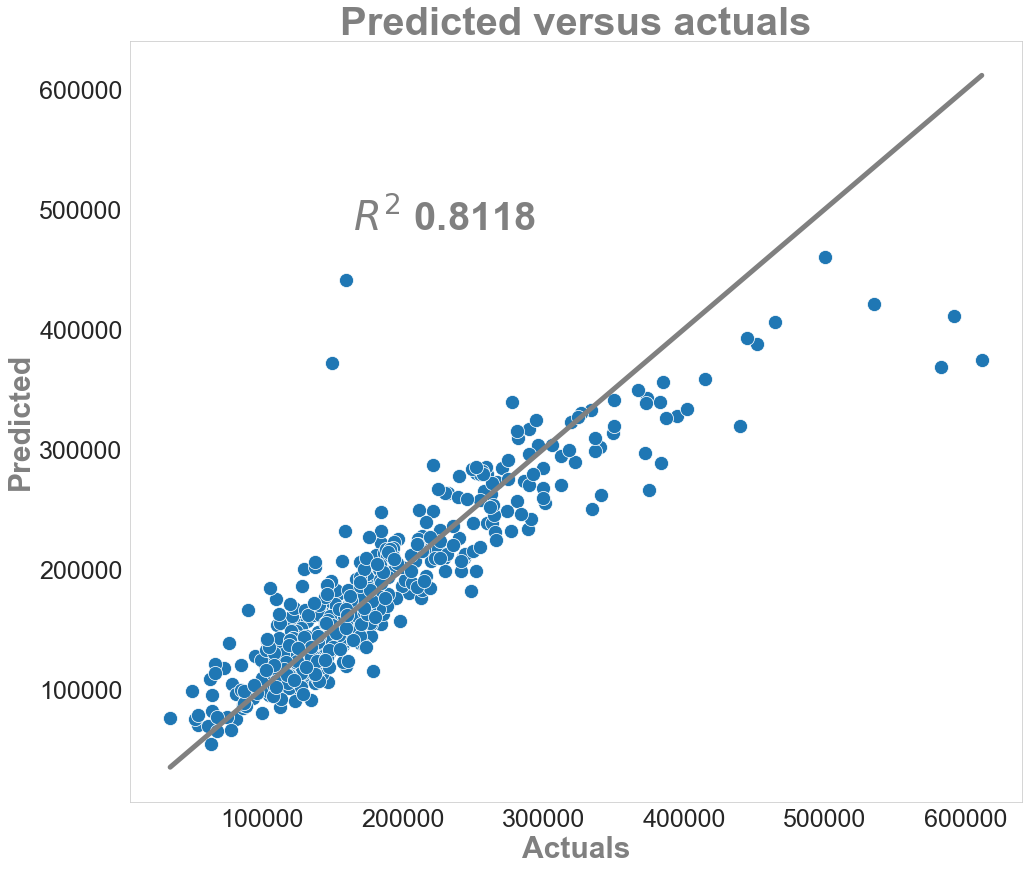

In [63]:
# Large scatter plot for presentation
large_scatter(y_trn_tst, pred_gs_trn_tst)


## Examine the model

In [48]:
# Get the kbest parameters
print(gs_model.best_estimator_.named_steps['kbest'])

print(gs_model.best_estimator_.named_steps['rfe'])


SelectKBest(k=10, score_func=<function f_regression at 0x1a255c5400>)
RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=9, step=1, verbose=0)


## Examine the intercept and coefficients

In [49]:
# Look at the variables after the transformations
columns = X1_trn.columns
columns = columns[gs_model.best_estimator_.named_steps['kbest'].get_support()]
columns = columns[gs_model.best_estimator_.named_steps['rfe'].get_support()]
print(columns)

Index(['over_qual', 'over_qual tot_bsmt_sf', 'over_qual gr_liv_area',
       'over_qual yr_sold', 'over_qual tot_rms_abv_grd', 'over_qual garg_cars',
       'over_qual garg_area', 'gr_liv_area garg_cars',
       'gr_liv_area garg_area'],
      dtype='object')


In [50]:
# get the intercept and coefficients
intercept = gs_model.best_estimator_.named_steps['rfe'].estimator_.intercept_
coefficients = gs_model.best_estimator_.named_steps['rfe'].estimator_.coef_


## Get the coefficients


In [51]:
model = pd.DataFrame(coefficients, index = columns, columns=['coeff'])
model

coeff
over_qual                  50630.698825
over_qual tot_bsmt_sf      19054.792925
over_qual gr_liv_area      49694.592498
over_qual yr_sold         -53033.027362
over_qual tot_rms_abv_grd -10092.836578
over_qual garg_cars       -53004.806718
over_qual garg_area        84064.209139
gr_liv_area garg_cars      76729.916120
gr_liv_area garg_area     -87483.677890

## Look at these variables in a ordinary linear regression model



In [52]:
# look at these results in a linear regression model
view_lr_summary(X1_trn_trn_s[columns],y_trn_trn)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     870.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        06:27:24   Log-Likelihood:                -18119.
No. Observations:                1538   AIC:                         3.626e+04
Df Residuals:                    1528   BIC:                         3.631e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1.821e+05    809.365    224.966      0.000     1.8e+05    1.84e+05
over_qual                  5.971e+04   2.87e+05      0.208      0.835   -5.04e+05    6.23e+05
over_qual tot_bsmt_sf       1.91e+04   1423.095     13.422      0.000    1.63e+04    2.19e+04
over_qual gr_liv_area      4.952e+04   4141.254     11.958      0.000    4.14e+04    5.76e+04
over_qual yr_sold         -6.196e+04   2.87e+05     -0.216      0.829   -6.25e+05    5.01e+05
over_qual tot_rms_abv_grd  -1.01e+04   2339.235     -4.318      0.000   -1.47e+04   -5512.055
over_qual garg_cars       -5.465e+04   9000.019     -6.072      0.000   -7.23e+04    -3.7e+04
over_qual garg_area        8.549e+04   8436.680     10.133      0.000    6.89e+04    1.02e+05
gr_liv_area garg_cars      7.852e+04   9766.738      8.040      0.000    5.94e+04    9.77e+04
gr_liv_area garg_area     -8.907e+04   9371.071     -9.504      0.000   -1.07e+05   -7.07e+04
==============================================================================
Omnibus:                      671.028   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53253.042
Skew:                          -1.134   Prob(JB):                         0.00
Kurtosis:                      31.738   Cond. No.                     1.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train the model on the entire training data set

In [55]:
# fit the model
gs_model.fit(X1_trn, y_trn)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a255c5400>)), ('rfe', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [10, 20, 30, 40, 50], 'rfe__n_features_to_select': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
# Generate predictions from the grid search model
pred_gs_tst = gs_model.predict(X1_tst)


### Get the coefficients 

In [59]:
# Look at the variables after the transformations
columns = X1_trn.columns
columns = columns[gs_model.best_estimator_.named_steps['kbest'].get_support()]
columns = columns[gs_model.best_estimator_.named_steps['rfe'].get_support()]
print(columns)

Index(['over_qual', '1st_flr_sf', 'over_qual tot_bsmt_sf',
       'over_qual gr_liv_area', 'over_qual yr_sold', 'tot_bsmt_sf gr_liv_area',
       'tot_bsmt_sf yr_sold', 'tot_bsmt_sf tot_rms_abv_grd',
       'tot_rms_abv_grd 1st_flr_sf'],
      dtype='object')


## Write data to files

### Write the predictions to a file

In [57]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_gs_tst),"pred_2f_Steve_Godfrey.csv" )


### Write the expanded data frame to a file

In [58]:
# Save the data to csv files
test_dataframe_name = "test_expanded_clean.csv"
train_dataframe_name = "train_expanded_clean.csv"

X1_tst.to_csv(os.path.join(data_path, test_dataframe_name), index = False)
X1_trn.to_csv(os.path.join(data_path, train_dataframe_name), index = False)


## References

* https://machinelearningmastery.com/feature-selection-machine-learning-python/
* https://stackoverflow.com/questions/34204898/how-to-get-the-coefficients-from-rfe-using-sklearn
